# Master thesis stuff

Import necessary packages and modules.

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

import graph
from quantumGraphSolverFVM import QuantumGraphSolverFVM

Set up constants.

In [2]:
xth_frame = 5
# Time discretization of PINN
N_b = 200
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of PINN
N_0 = 200
# Spatial discretization of FVM
nx = N_0 + 1

Generate Graph.

In [3]:
graph_test = graph.Example3()
graph_test.buildGraph()

Run FVM solver.

In [4]:
fvm_solver = QuantumGraphSolverFVM(graph_test)
u = fvm_solver.solve(nx=nx, nt=nt)

Define function for writing csv.

In [5]:
def write_csv(fvm, nx, j=0):
        u = fvm.u
        he = 1.0 / nx
        
        with open('FVM_results.csv', 'w', newline='') as f:
            thewriter = csv.writer(f)
            for i in range(np.shape(u)[0]-3):
                for j in range(np.shape(u)[1]):
                    thewriter.writerow([i * he, j * 1./100, u[i,j]])
                    # the right input parameters (x, t) are needed

Write csv.

In [6]:
write_csv(fvm_solver, nx)

Load Data.

In [7]:
dataset = np.loadtxt('FVM_results.csv', delimiter=',')
x_csv = tf.convert_to_tensor(dataset[::1000,0])
t_csv = tf.convert_to_tensor(dataset[:1000,1])
u_csv = tf.convert_to_tensor(dataset[:,2])
u_csv_matrix = tf.reshape(u_csv, (398,1000))
xt_csv = tf.convert_to_tensor(dataset[:,0:2])

Some plotting.

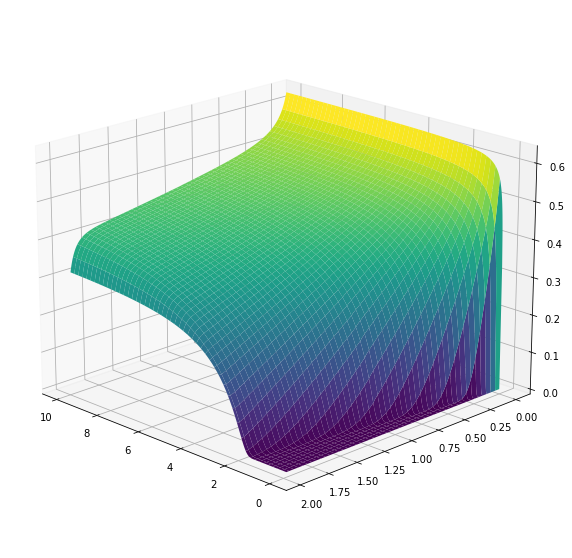

In [8]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

T, X = tf.meshgrid(t_csv, x_csv)
U = u_csv_matrix
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

A somewhat different plot.

<Axes3DSubplot:xlabel='$x$', ylabel='$y$'>

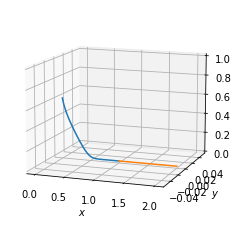

In [9]:
fvm_solver.plotNetwork(j=40)

# Approximating with FNN

Generate Neural Network

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

ffn = Sequential()
ffn.add(Dense(16, input_dim=2, activation='relu'))
ffn.add(Dense(16, activation='relu'))
ffn.add(Dense(16, activation='relu'))
ffn.add(Dense(1))

ffn.compile(loss='mean_squared_error', optimizer='adam')

Split into training and test data.

In [11]:
xt_train, xt_test, u_train, u_test = train_test_split(xt_csv.numpy(), u_csv.numpy(), test_size=0.2)

Train Model.

In [12]:
ffn.fit(xt_train, u_train, epochs=3, batch_size=100)

Epoch 1/3
3184/3184 [==============================] - 8s 2ms/step - loss: 9.2980e-04
Epoch 2/3
3184/3184 [==============================] - 6s 2ms/step - loss: 6.2457e-05
Epoch 3/3
3184/3184 [==============================] - 4s 1ms/step - loss: 5.2312e-05


Plot results.

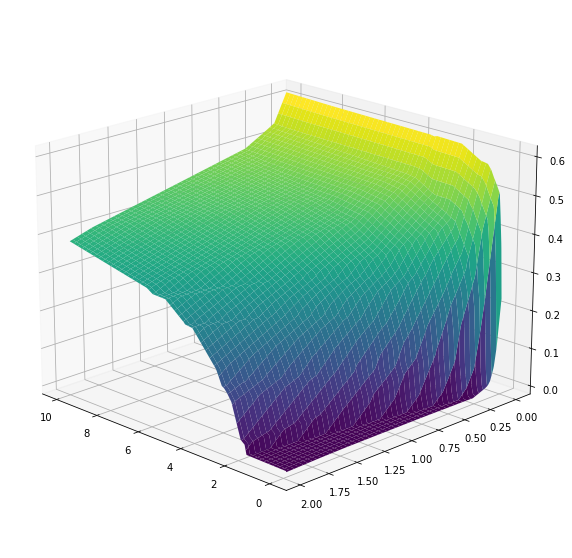

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

T, X = tf.meshgrid(t_csv, x_csv)
XT = tf.stack([tf.reshape(X,-1), tf.reshape(T,-1)],axis=1)
U = ffn(XT)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# Approximating with ResNet

Define Residual Network.

In [22]:
class ResNet(tf.keras.Model):

    def __init__(self,
                 ResNetLayers=3,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 **kwargs):
        
        super(ResNet, self).__init__(**kwargs)
        
        RNact = tf.keras.activations.get('relu')
        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = 2
        self.output_dim = 1

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi

Generate Residual network.

In [23]:
resnet = ResNet()
resnet.compile(loss='mean_squared_error', optimizer='adam')

Train network.

In [24]:
resnet.fit(xt_train, u_train, epochs=3, batch_size=100)

Epoch 1/3
3184/3184 [==============================] - 6s 2ms/step - loss: 0.5652
Epoch 2/3
3184/3184 [==============================] - 7s 2ms/step - loss: 0.0026
Epoch 3/3
3184/3184 [==============================] - 6s 2ms/step - loss: 0.0016


Plot Results.

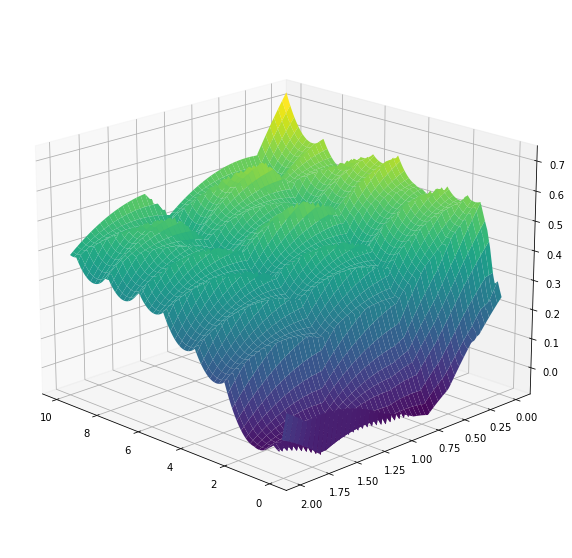

In [25]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

T, X = tf.meshgrid(t_csv, x_csv)
XT = tf.stack([tf.reshape(X,-1), tf.reshape(T,-1)],axis=1)
U = resnet(XT)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# NN for each edge

We define a neural network representing the function evaluation on each edge. We stick with the name PINN for now, even if these NN are not physics informed, since I stole the class anyway. 

In [26]:
import networkx as nx
DTYPE='float64'

class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 activation= 'relu',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation= 'relu')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

Now we define the struture that joins the neural networks on each edge.

In [27]:
class GraphPINN():
    
    def __init__(self, A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        self.A = A
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij)

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))

We generate the networks on the individual edges.

In [28]:
gPINN = GraphPINN(graph_test.A, graph_test.dirichletNodes, graph_test.dirichletAlpha, graph_test.dirichletBeta, graph_test.lb, graph_test.ub)

Initialized 2 neural nets.


We define the solver class. It should be noted that no information about the nodes enters here. 

In [29]:
from time import time 

class graphPINNSolver(object):
    def __init__(self, graphPINN, data):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self.output = tf.convert_to_tensor(data[:,2], dtype=DTYPE)
        
        self.xt = tf.convert_to_tensor(data[:,0:2], dtype=DTYPE)

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        
        self.nvar = len(self.trainable_variables)

         
    def _fvals0(self, x, t):

        # Initialize lists for values and derivatives
        u = []
        xt = tf.stack([x, t], axis=1)
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](xt)[:,0])

        return u
            
    
    def loss_fn(self):
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        u = self._fvals0(self.xt[:,0], self.xt[:,1])
        
        loss = mse(u - self.output)
        
        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

We generate the solver and apply the Adam optimizer. 

In [30]:
solver = graphPINNSolver(gPINN, dataset)
solver.graphPINN.NNs[0](tf.constant([[1., 1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.36842784]], dtype=float32)>

In [31]:
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=201)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00000  1.53322672e-01   0.79
00020  8.32192681e-02   4.24
00040  7.78758479e-02   7.22
00060  7.75431699e-02   10.37
00080  7.73946252e-02   13.66
00100  7.73237107e-02   17.03
00120  7.72693722e-02   20.82
00140  7.72276007e-02   24.69
00160  7.72031786e-02   28.29
00180  7.71919244e-02   31.88
00200  7.71851932e-02   35.48


Doing some plotting. Hopefully something usable.

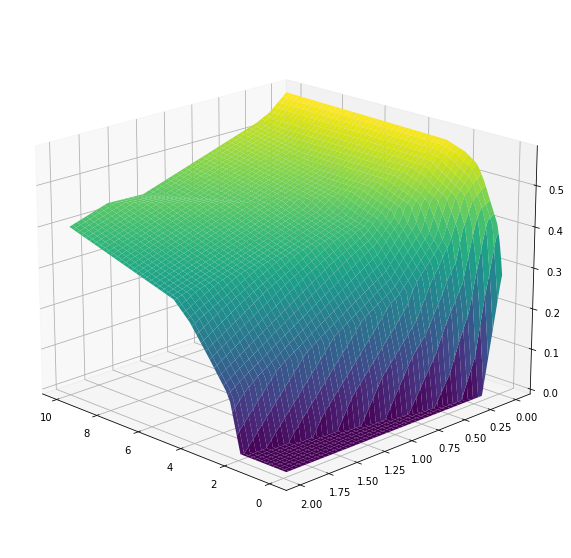

In [32]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

T, X = tf.meshgrid(t_csv, x_csv)
XT = tf.stack([tf.reshape(X,-1), tf.reshape(T,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](XT)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# ResNet for each edge

We define a residual network for each edge. Again, no physics (information about pde) flows in. 

In [33]:
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=2,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('relu')
        

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [34]:
class GraphPINN_ResNet():
    
    def __init__(self, A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        self.A = A
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij)

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN_ResNet(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))

We generate a residual network for each edge.

In [35]:
gPINN_ResNet = GraphPINN_ResNet(graph_test.A, graph_test.dirichletNodes, graph_test.dirichletAlpha, graph_test.dirichletBeta, graph_test.lb, graph_test.ub)

Initialized 2 neural nets.


We create a new solver and use Adam again -> Very slow.

In [36]:
solver_ResNet = graphPINNSolver(gPINN_ResNet, dataset)
solver_ResNet.graphPINN.NNs[0](tf.constant([[1., 1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.98782337]], dtype=float32)>

In [37]:
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_ResNet.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00000  4.45023732e+02   2.70
00020  2.92776359e+01   6.40
00040  8.69935346e+00   9.99
00060  4.67067610e+00   13.71
00080  2.97652385e+00   17.03
00100  1.89288848e+00   20.80
00120  1.35276001e+00   24.59
00140  1.03602463e+00   28.37
00160  7.88518194e-01   32.10
00180  5.79838307e-01   36.13
00200  4.21493067e-01   40.12
00220  3.14617245e-01   44.13
00240  2.40131398e-01   48.25
00260  1.86684735e-01   52.21
00280  1.47989121e-01   56.28
00300  1.19797616e-01   60.37
00320  9.90385393e-02   64.61
00340  8.36211922e-02   68.61
00360  7.20866845e-02   72.49
00380  6.34137267e-02   76.39
00400  5.68496362e-02   80.52
00420  5.18332708e-02   84.41
00440  4.79480985e-02   88.30
00460  4.48881107e-02   92.20
00480  4.24299816e-02   96.59
00500  4.04116854e-02   101.50
00520  3.87178790e-02   106.46
00540  3.72664720e-02   111.64
00560  3.59984939e-02   116.69
00580  3.48710582e-02   121.08
00600  3.4158

Some plotting again.

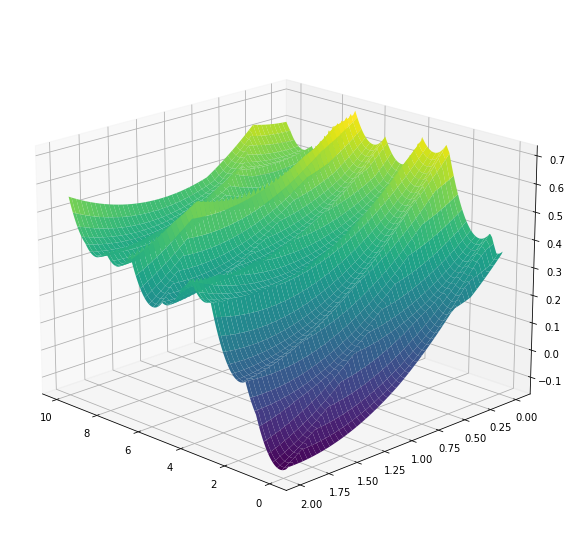

In [38]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


T, X = tf.meshgrid(t_csv, x_csv)
XT = tf.stack([tf.reshape(X,-1), tf.reshape(T,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](XT) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


# Another approach. 

In [60]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

In [61]:
xt_train, xt_test, u_train, u_test = train_test_split(xt, u, test_size=0.2)

In [64]:
regr = MLPRegressor(hidden_layer_sizes=[16], max_iter=500, tol=0)
regr.fit(xt_train,u_train)
predictions = model.predict(xt_test)

AttributeError: 'MLPClassifier' object has no attribute 'n_layers_'

# Stuff

In [ ]:
import tensorflow as tf

In [ ]:
mse = lambda x : tf.reduce_mean(tf.square(x))

In [ ]:
x = tf.Variable([5.])

In [ ]:
tmin = 0.
tmax = 10.
xmin = 0.
xmax = 1.

In [ ]:
lb = np.array([tmin, xmin])

# Upper bounds
ub = np.array([tmax, xmax])

In [ ]:
X_r = tf.random.uniform((4000,2), lb, ub, dtype='float64')

In [2]:
xspace = tf.linspace(1, 401, 401)
tspace = tf.linspace(1, 1000, 1000)
T, X = tf.meshgrid(tspace, xspace)

NameError: name 'tf' is not defined

In [1]:
T[89,90].numpy()

NameError: name 'T' is not defined

In [45]:
c = tf.keras.layers.Dense(1, use_bias=False)

In [46]:
input_tensor = tf.Variable([[1., 3.]])

In [47]:
input_tensor

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[1., 3.]], dtype=float32)>

In [48]:
c(input_tensor)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.936172]], dtype=float32)>